#  TORCH.UTILS.DATA 包

At the heart of PyTorch data loading utility is the `torch.utils.data.DataLoader class`. It represents a Python iterable over a dataset, with support for
- [map-style and iterable-style datasets,](https://pytorch.org/docs/stable/data.html#dataset-types)
- [customizing data loading order,](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)
- [automatic batching,](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data)
- [single- and multi-process data loading,](https://pytorch.org/docs/stable/data.html#single-and-multi-process-data-loading)
- [automatic memory pinning.](https://pytorch.org/docs/stable/data.html#memory-pinning)

### 1. Dataset Types

DataLoader构造时，最重要的参数是`dataset`，这个dataset提供了数据。Pytorch目前支持2种不同的数据集：
- map-style datasets,      （map类的数据集）
- iterable-style datasets. （迭代类的数据集）

#### 1.1 Map-style datasets

map-style dataset需要实现`__getitem__()` 和 `__len__()`方法，并且是使用 indices/keys（可能是非整数形式）去获取数据。

例如，当访问`dataset[idx]`，可以访问到存在某个目录或磁盘的 `第idx` 张图片。

关于更多的细节，请看[Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

#### 1.2 Iterable-style datasets

iterable-style dataset 是 `IterableDataset`的子类的实例，代表一个可以让`sampler`迭代的数据集。这类数据集特别适合 `随机读取成本高 或 不可能` 和 `batch size依赖对应数据集`  这类场景。

例如，当调用`iter(dataset)`，数据集可以从 `数据库 | 远程服务器 | 实时的logs` 读取数据流。

关于更多的细节，请看[IterableDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset)

**Notice**

When using an IterableDataset with multi-process data loading. The same dataset object is replicated on each worker process, and thus the replicas must be configured differently to avoid duplicated data. 

See [IterableDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset) documentations for how to achieve this.

#### 1.3 torch.utils.data.Dataset类

定义： 一个代表数据集的`抽象类`。[link](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

所有数据集，都应该继承它。为了根据`给定的key`获取1各数据样本，所有`自定义的数据集`必须重写`__getitem__()方法`；也可以选择性地重写`__len__()方法`，这个方法为了返回数据集的size，通常某些DataLoader会用到这个方法。

**Notice**

DataLoader默认构造的是整型的index sampler，即调用数据通过整数索引调用。如果想要在DataLoader中使用non-integral indices/keys的数据集，必须要自定义sampler。

**Code - Dataset**
```
class Dataset(object):
    r"""An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs a index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])


    # No `def __len__(self)` default?
    # See NOTE [ Lack of Default `__len__` in Python Abstract Base Classes ]
    # in pytorch/torch/utils/data/sampler.py
```

**Code - Sampler.py** 解释为什么不在Dataset中就实现`__len__()方法`
```
class Sampler(object):
    # NOTE [ Lack of Default `__len__` in Python Abstract Base Classes ]
    #
    # Many times we have an abstract class representing a collection/iterable of
    # data, e.g., `torch.utils.data.Sampler`, with its subclasses optionally
    # implementing a `__len__` method. In such cases, we must make sure to not
    # provide a default implementation, because both straightforward default
    # implementations have their issues:
    #
    #   + `return NotImplemented`:
    #     Calling `len(subclass_instance)` raises:
    #       TypeError: 'NotImplementedType' object cannot be interpreted as an integer
    #
    #   + `raise NotImplementedError()`:
    #     This prevents triggering some fallback behavior. E.g., the built-in
    #     `list(X)` tries to call `len(X)` first, and executes a different code
    #     path if the method is not found or `NotImplemented` is returned, while
    #     raising an `NotImplementedError` will propagate and and make the call
    #     fail where it could have use `__iter__` to complete the call.
    #
    # Thus, the only two sensible things to do are
    #
    #   + **not** provide a default `__len__`.
    #
    #   + raise a `TypeError` instead, which is what Python uses when users call
    #     a method that is not defined on an object.
    #     (@ssnl verifies that this works on at least Python 3.7.)
```

**Figure - 相关子类**

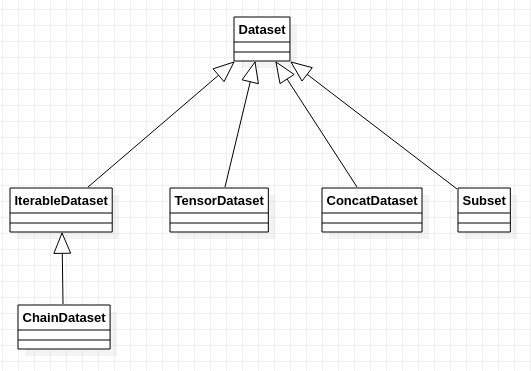

#### 1.4 TORCHVISION.DATASETS 

[TORCHVISION-Datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision-datasets)都是[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)的子类。这些dataset都有实现了父类(`Dataset`)2个的方法：
- __getitem__ 方法
- __len__ 方法

此外，这些数据集都可以传入[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.DataLoader)对象，这个DataLoader可以使用`torch.multiprocessing workers`并行加载多个[samples](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Sampler)。例如：

### 2. Data Loading Order and Sampler

对于 `iterable-style` datasets, 数据加载顺序完全由 `user-defined iterable` 控制。这样就更容易实现 `批量读取` 和 `动态批大小` (每次yield一个批量的样本)。

在数据加载时，torch.utils.data.Sampler classes 用于指定indices/keys的顺序。 它们也代表了可迭代的对象。例如，通常在用stochastic gradient decent (SGD)的情况下，采样器可以随机产生一个 indices 列表，方便 mini-batch SGD每次调用一小批数据。

一个`sequential or shuffled sampler`可以根据`shuffle参数`在DataLoader中自动构造。当然，用户也可以使用`sampler参数`指定一个自定义的`Sampler对象`，这个对象负责获取下一个`index/key`。

A custom Sampler that yields a list of batch indices at a time can be passed as the batch_sampler argument. Automatic batching can also be enabled via batch_size and drop_last arguments. See the next section for more details on this.

**Notice**

Neither sampler nor batch_sampler is compatible with iterable-style datasets, since such datasets have no notion of a key or an index.

#### 2.1 torch.utils.data.Sampler - 采样器类

定义： 用于指定采样规则的`采样器`。

**Figure - 相关子类**

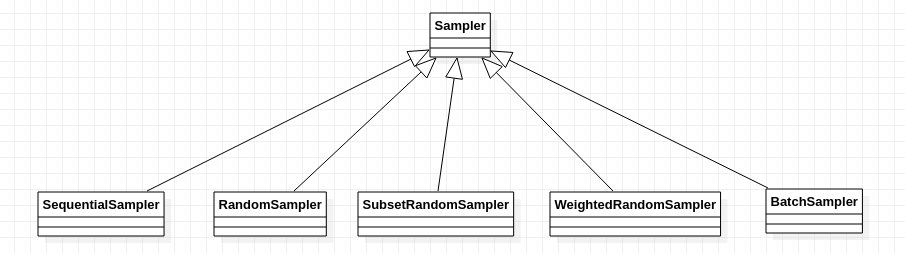

### 3. Loading Batched and Non-Batched Data

### 4. Single- and Multi-process Data Loading